In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "SL50"
station_dv = "SL50 (kPa)"
station_path = "data/station_inputs/sl50_rl50_for_maps.csv"
input_model_path = (
    "data/model_inputs/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc"
)
medians = {"value": 2.4, "action": "multiply"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = True


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,SL50 (kPa),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,558,1009,1.0,-4.286849,10.373390,42.2756,-82.9556,190.0,WINDSOR A,ON,0.614799,1.178766
1,559,1009,1.2,-4.227125,10.379271,42.3333,-82.9333,188.0,WINDSOR RIVERSIDE,ON,0.622597,1.396802
2,576,1017,1.5,-3.494586,10.713492,42.9922,-82.3047,181.0,SARNIA AIRPORT,ON,0.739112,1.470759


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

1.5000000000000002

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/514 [00:00<?, ?it/s]

  0%|          | 2/514 [00:00<02:08,  4.00it/s]

  1%|          | 3/514 [00:00<02:43,  3.12it/s]

  1%|          | 4/514 [00:01<03:20,  2.54it/s]

  1%|          | 5/514 [00:02<03:42,  2.29it/s]

  1%|          | 6/514 [00:02<03:59,  2.12it/s]

  1%|▏         | 7/514 [00:03<04:12,  2.01it/s]

  2%|▏         | 8/514 [00:03<04:11,  2.01it/s]

  2%|▏         | 9/514 [00:04<04:15,  1.98it/s]

  2%|▏         | 10/514 [00:04<04:25,  1.90it/s]

  2%|▏         | 11/514 [00:05<04:34,  1.84it/s]

  2%|▏         | 12/514 [00:06<04:46,  1.75it/s]

  3%|▎         | 13/514 [00:06<04:42,  1.77it/s]

  3%|▎         | 14/514 [00:07<04:43,  1.77it/s]

  3%|▎         | 15/514 [00:07<04:40,  1.78it/s]

  3%|▎         | 16/514 [00:08<04:40,  1.77it/s]

  3%|▎         | 17/514 [00:08<04:40,  1.77it/s]

  4%|▎         | 18/514 [00:09<04:35,  1.80it/s]

  4%|▎         | 19/514 [00:09<04:32,  1.82it/s]

  4%|▍         | 20/514 [00:10<04:31,  1.82it/s]

  4%|▍         | 21/514 [00:10<04:28,  1.84it/s]

  4%|▍         | 22/514 [00:11<04:28,  1.83it/s]

  4%|▍         | 23/514 [00:12<04:38,  1.77it/s]

  5%|▍         | 24/514 [00:12<04:43,  1.73it/s]

  5%|▍         | 25/514 [00:13<04:37,  1.76it/s]

  5%|▌         | 26/514 [00:13<04:31,  1.80it/s]

  5%|▌         | 27/514 [00:14<04:28,  1.81it/s]

  5%|▌         | 28/514 [00:14<04:33,  1.78it/s]

  6%|▌         | 29/514 [00:16<06:12,  1.30it/s]

  6%|▌         | 30/514 [00:17<07:50,  1.03it/s]

  6%|▌         | 31/514 [00:18<06:58,  1.16it/s]

  6%|▌         | 32/514 [00:18<06:22,  1.26it/s]

  6%|▋         | 33/514 [00:20<07:25,  1.08it/s]

  7%|▋         | 34/514 [00:20<06:32,  1.22it/s]

  7%|▋         | 35/514 [00:22<08:11,  1.03s/it]

  7%|▋         | 36/514 [00:23<08:40,  1.09s/it]

  7%|▋         | 37/514 [00:25<10:15,  1.29s/it]

  7%|▋         | 38/514 [00:27<11:28,  1.45s/it]

  8%|▊         | 39/514 [00:28<11:13,  1.42s/it]

  8%|▊         | 40/514 [00:28<09:21,  1.18s/it]

  8%|▊         | 41/514 [00:30<10:58,  1.39s/it]

  8%|▊         | 42/514 [00:32<11:18,  1.44s/it]

  8%|▊         | 43/514 [00:33<09:34,  1.22s/it]

  9%|▊         | 44/514 [00:33<08:08,  1.04s/it]

  9%|▉         | 45/514 [00:34<07:05,  1.10it/s]

  9%|▉         | 46/514 [00:35<06:47,  1.15it/s]

  9%|▉         | 47/514 [00:36<08:05,  1.04s/it]

  9%|▉         | 48/514 [00:38<09:10,  1.18s/it]

 10%|▉         | 49/514 [00:39<10:47,  1.39s/it]

 10%|▉         | 50/514 [00:41<10:22,  1.34s/it]

 10%|▉         | 51/514 [00:42<11:18,  1.47s/it]

 10%|█         | 52/514 [00:43<09:07,  1.19s/it]

 10%|█         | 53/514 [00:45<10:24,  1.36s/it]

 11%|█         | 54/514 [00:46<11:16,  1.47s/it]

 11%|█         | 55/514 [00:48<10:52,  1.42s/it]

 11%|█         | 56/514 [00:48<08:58,  1.18s/it]

 11%|█         | 57/514 [00:50<10:35,  1.39s/it]

 11%|█▏        | 58/514 [00:52<11:24,  1.50s/it]

 11%|█▏        | 59/514 [00:54<12:15,  1.62s/it]

 12%|█▏        | 60/514 [00:56<12:32,  1.66s/it]

 12%|█▏        | 61/514 [00:56<10:08,  1.34s/it]

 12%|█▏        | 62/514 [00:57<08:26,  1.12s/it]

 12%|█▏        | 63/514 [00:59<10:05,  1.34s/it]

 12%|█▏        | 64/514 [01:01<11:04,  1.48s/it]

 13%|█▎        | 65/514 [01:02<11:51,  1.59s/it]

 13%|█▎        | 66/514 [01:04<11:41,  1.57s/it]

 13%|█▎        | 67/514 [01:06<12:02,  1.62s/it]

 13%|█▎        | 68/514 [01:07<12:28,  1.68s/it]

 13%|█▎        | 69/514 [01:09<12:53,  1.74s/it]

 14%|█▎        | 70/514 [01:11<12:52,  1.74s/it]

 14%|█▍        | 71/514 [01:13<12:45,  1.73s/it]

 14%|█▍        | 72/514 [01:15<12:52,  1.75s/it]

 14%|█▍        | 73/514 [01:16<12:57,  1.76s/it]

 14%|█▍        | 74/514 [01:18<12:54,  1.76s/it]

 15%|█▍        | 75/514 [01:20<12:50,  1.75s/it]

 15%|█▍        | 76/514 [01:22<12:59,  1.78s/it]

 15%|█▍        | 77/514 [01:22<10:13,  1.40s/it]

 15%|█▌        | 78/514 [01:24<10:05,  1.39s/it]

 15%|█▌        | 79/514 [01:25<10:51,  1.50s/it]

 16%|█▌        | 80/514 [01:27<11:31,  1.59s/it]

 16%|█▌        | 81/514 [01:29<11:47,  1.63s/it]

 16%|█▌        | 82/514 [01:30<10:54,  1.51s/it]

 16%|█▌        | 83/514 [01:31<08:48,  1.23s/it]

 16%|█▋        | 84/514 [01:32<09:51,  1.37s/it]

 17%|█▋        | 85/514 [01:34<11:01,  1.54s/it]

 17%|█▋        | 86/514 [01:35<08:51,  1.24s/it]

 17%|█▋        | 87/514 [01:35<07:22,  1.04s/it]

 17%|█▋        | 88/514 [01:37<09:22,  1.32s/it]

 17%|█▋        | 89/514 [01:39<10:47,  1.52s/it]

 18%|█▊        | 90/514 [01:41<10:05,  1.43s/it]

 18%|█▊        | 91/514 [01:41<08:14,  1.17s/it]

 18%|█▊        | 92/514 [01:42<06:54,  1.02it/s]

 18%|█▊        | 93/514 [01:44<08:42,  1.24s/it]

 18%|█▊        | 94/514 [01:45<08:21,  1.19s/it]

 18%|█▊        | 95/514 [01:47<09:51,  1.41s/it]

 19%|█▊        | 96/514 [01:47<08:02,  1.16s/it]

 19%|█▉        | 97/514 [01:48<06:42,  1.04it/s]

 19%|█▉        | 98/514 [01:49<08:19,  1.20s/it]

 19%|█▉        | 99/514 [01:51<09:33,  1.38s/it]

 19%|█▉        | 100/514 [01:53<10:28,  1.52s/it]

 20%|█▉        | 101/514 [01:54<08:26,  1.23s/it]

 20%|█▉        | 102/514 [01:55<08:26,  1.23s/it]

 20%|██        | 103/514 [01:57<09:42,  1.42s/it]

 20%|██        | 104/514 [01:58<10:22,  1.52s/it]

 20%|██        | 105/514 [01:59<08:16,  1.21s/it]

 21%|██        | 106/514 [01:59<06:50,  1.01s/it]

 21%|██        | 107/514 [02:00<05:54,  1.15it/s]

 21%|██        | 108/514 [02:01<05:56,  1.14it/s]

 21%|██        | 109/514 [02:02<06:25,  1.05it/s]

 21%|██▏       | 110/514 [02:03<07:01,  1.04s/it]

 22%|██▏       | 111/514 [02:04<06:05,  1.10it/s]

 22%|██▏       | 112/514 [02:06<07:59,  1.19s/it]

 22%|██▏       | 113/514 [02:07<07:52,  1.18s/it]

 22%|██▏       | 114/514 [02:08<07:44,  1.16s/it]

 22%|██▏       | 115/514 [02:09<06:31,  1.02it/s]

 23%|██▎       | 116/514 [02:09<05:43,  1.16it/s]

 23%|██▎       | 117/514 [02:10<05:04,  1.30it/s]

 23%|██▎       | 118/514 [02:10<04:33,  1.45it/s]

 23%|██▎       | 119/514 [02:11<05:26,  1.21it/s]

 23%|██▎       | 120/514 [02:12<04:49,  1.36it/s]

 24%|██▎       | 121/514 [02:12<04:27,  1.47it/s]

 24%|██▎       | 122/514 [02:13<04:21,  1.50it/s]

 24%|██▍       | 123/514 [02:14<04:12,  1.55it/s]

 24%|██▍       | 124/514 [02:14<04:00,  1.62it/s]

 24%|██▍       | 125/514 [02:15<03:52,  1.67it/s]

 25%|██▍       | 126/514 [02:15<03:42,  1.75it/s]

 25%|██▍       | 127/514 [02:16<03:35,  1.80it/s]

 25%|██▍       | 128/514 [02:17<04:34,  1.40it/s]

 25%|██▌       | 129/514 [02:18<06:09,  1.04it/s]

 25%|██▌       | 130/514 [02:19<05:23,  1.19it/s]

 25%|██▌       | 131/514 [02:20<04:50,  1.32it/s]

 26%|██▌       | 132/514 [02:21<05:37,  1.13it/s]

 26%|██▌       | 133/514 [02:22<05:49,  1.09it/s]

 26%|██▌       | 134/514 [02:23<05:59,  1.06it/s]

 26%|██▋       | 135/514 [02:23<05:09,  1.22it/s]

 26%|██▋       | 136/514 [02:24<04:41,  1.34it/s]

 27%|██▋       | 137/514 [02:24<04:16,  1.47it/s]

 27%|██▋       | 138/514 [02:25<03:58,  1.57it/s]

 27%|██▋       | 139/514 [02:26<05:11,  1.20it/s]

 27%|██▋       | 140/514 [02:27<05:43,  1.09it/s]

 27%|██▋       | 141/514 [02:28<05:00,  1.24it/s]

 28%|██▊       | 142/514 [02:28<04:28,  1.38it/s]

 28%|██▊       | 143/514 [02:29<05:05,  1.21it/s]

 28%|██▊       | 144/514 [02:31<05:37,  1.10it/s]

 28%|██▊       | 145/514 [02:31<04:54,  1.25it/s]

 28%|██▊       | 146/514 [02:32<04:26,  1.38it/s]

 29%|██▊       | 147/514 [02:32<04:07,  1.48it/s]

 29%|██▉       | 148/514 [02:33<03:53,  1.57it/s]

 29%|██▉       | 149/514 [02:34<04:44,  1.28it/s]

 29%|██▉       | 150/514 [02:34<04:24,  1.38it/s]

 29%|██▉       | 151/514 [02:35<04:05,  1.48it/s]

 30%|██▉       | 152/514 [02:36<04:58,  1.21it/s]

 30%|██▉       | 153/514 [02:37<04:37,  1.30it/s]

 30%|██▉       | 154/514 [02:37<04:14,  1.41it/s]

 30%|███       | 155/514 [02:39<05:54,  1.01it/s]

 30%|███       | 156/514 [02:40<06:40,  1.12s/it]

 31%|███       | 157/514 [02:41<05:36,  1.06it/s]

 31%|███       | 158/514 [02:42<06:32,  1.10s/it]

 31%|███       | 159/514 [02:44<07:28,  1.26s/it]

 31%|███       | 160/514 [02:45<07:19,  1.24s/it]

 31%|███▏      | 161/514 [02:46<06:53,  1.17s/it]

 32%|███▏      | 162/514 [02:47<05:47,  1.01it/s]

 32%|███▏      | 163/514 [02:47<04:55,  1.19it/s]

 32%|███▏      | 164/514 [02:48<04:23,  1.33it/s]

 32%|███▏      | 165/514 [02:49<05:39,  1.03it/s]

 32%|███▏      | 166/514 [02:50<05:43,  1.01it/s]

 32%|███▏      | 167/514 [02:51<05:45,  1.01it/s]

 33%|███▎      | 168/514 [02:52<05:48,  1.01s/it]

 33%|███▎      | 169/514 [02:54<05:56,  1.03s/it]

 33%|███▎      | 170/514 [02:55<06:24,  1.12s/it]

 33%|███▎      | 171/514 [02:56<06:14,  1.09s/it]

 33%|███▎      | 172/514 [02:57<06:35,  1.16s/it]

 34%|███▎      | 173/514 [02:58<06:25,  1.13s/it]

 34%|███▍      | 174/514 [02:59<06:23,  1.13s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: In addition: 


R[write to console]: Warning messages:



R[write to console]: 1: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: 2: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: Timing stopped at: 0.028 0 0.025



 34%|███▍      | 175/514 [03:00<04:44,  1.19it/s]

 34%|███▍      | 176/514 [03:00<04:19,  1.30it/s]

 34%|███▍      | 177/514 [03:02<05:31,  1.02it/s]

 35%|███▍      | 178/514 [03:03<05:57,  1.06s/it]

 35%|███▍      | 179/514 [03:04<06:53,  1.23s/it]

 35%|███▌      | 180/514 [03:05<06:25,  1.16s/it]

 35%|███▌      | 181/514 [03:07<06:27,  1.16s/it]

 35%|███▌      | 182/514 [03:07<05:26,  1.02it/s]

 36%|███▌      | 183/514 [03:08<05:46,  1.05s/it]

 36%|███▌      | 184/514 [03:09<05:08,  1.07it/s]

 36%|███▌      | 185/514 [03:10<04:32,  1.21it/s]

 36%|███▌      | 186/514 [03:10<04:19,  1.26it/s]

 36%|███▋      | 187/514 [03:12<05:33,  1.02s/it]

 37%|███▋      | 188/514 [03:13<06:05,  1.12s/it]

 37%|███▋      | 189/514 [03:15<06:46,  1.25s/it]

 37%|███▋      | 190/514 [03:16<06:54,  1.28s/it]

 37%|███▋      | 191/514 [03:18<07:14,  1.35s/it]

 37%|███▋      | 192/514 [03:19<06:53,  1.28s/it]

 38%|███▊      | 193/514 [03:19<05:43,  1.07s/it]

 38%|███▊      | 194/514 [03:21<06:44,  1.26s/it]

 38%|███▊      | 195/514 [03:23<07:24,  1.39s/it]

 38%|███▊      | 196/514 [03:24<06:59,  1.32s/it]

 38%|███▊      | 197/514 [03:25<06:43,  1.27s/it]

 39%|███▊      | 198/514 [03:27<07:27,  1.42s/it]

 39%|███▊      | 199/514 [03:28<06:56,  1.32s/it]

 39%|███▉      | 200/514 [03:29<06:44,  1.29s/it]

 39%|███▉      | 201/514 [03:30<06:39,  1.28s/it]

 39%|███▉      | 202/514 [03:32<06:31,  1.26s/it]

 39%|███▉      | 203/514 [03:33<06:11,  1.19s/it]

 40%|███▉      | 204/514 [03:34<06:31,  1.26s/it]

 40%|███▉      | 205/514 [03:35<06:34,  1.28s/it]

 40%|████      | 206/514 [03:37<07:03,  1.37s/it]

 40%|████      | 207/514 [03:38<07:02,  1.38s/it]

 40%|████      | 208/514 [03:40<07:13,  1.42s/it]

 41%|████      | 209/514 [03:41<07:18,  1.44s/it]

 41%|████      | 210/514 [03:43<07:03,  1.39s/it]

 41%|████      | 211/514 [03:44<06:45,  1.34s/it]

 41%|████      | 212/514 [03:44<05:29,  1.09s/it]

 41%|████▏     | 213/514 [03:46<06:01,  1.20s/it]

 42%|████▏     | 214/514 [03:48<06:42,  1.34s/it]

 42%|████▏     | 215/514 [03:49<07:04,  1.42s/it]

 42%|████▏     | 216/514 [03:50<06:56,  1.40s/it]

 42%|████▏     | 217/514 [03:52<07:11,  1.45s/it]

 42%|████▏     | 218/514 [03:54<07:15,  1.47s/it]

 43%|████▎     | 219/514 [03:55<07:44,  1.58s/it]

 43%|████▎     | 220/514 [03:57<07:44,  1.58s/it]

 43%|████▎     | 221/514 [03:58<06:11,  1.27s/it]

 43%|████▎     | 222/514 [03:59<06:17,  1.29s/it]

 43%|████▎     | 223/514 [04:00<06:24,  1.32s/it]

 44%|████▎     | 224/514 [04:01<05:58,  1.24s/it]

 44%|████▍     | 225/514 [04:02<04:57,  1.03s/it]

 44%|████▍     | 226/514 [04:03<04:52,  1.01s/it]

 44%|████▍     | 227/514 [04:04<04:56,  1.03s/it]

 44%|████▍     | 228/514 [04:04<04:11,  1.14it/s]

 45%|████▍     | 229/514 [04:05<03:42,  1.28it/s]

 45%|████▍     | 230/514 [04:06<04:03,  1.17it/s]

 45%|████▍     | 231/514 [04:07<03:35,  1.31it/s]

 45%|████▌     | 232/514 [04:08<04:44,  1.01s/it]

 45%|████▌     | 233/514 [04:10<05:30,  1.18s/it]

 46%|████▌     | 234/514 [04:11<05:47,  1.24s/it]

 46%|████▌     | 235/514 [04:12<05:45,  1.24s/it]

 46%|████▌     | 236/514 [04:14<06:03,  1.31s/it]

 46%|████▌     | 237/514 [04:15<06:01,  1.30s/it]

 46%|████▋     | 238/514 [04:16<05:59,  1.30s/it]

 46%|████▋     | 239/514 [04:18<06:04,  1.33s/it]

 47%|████▋     | 240/514 [04:19<06:02,  1.32s/it]

 47%|████▋     | 241/514 [04:20<05:02,  1.11s/it]

 47%|████▋     | 242/514 [04:21<05:28,  1.21s/it]

 47%|████▋     | 243/514 [04:22<05:36,  1.24s/it]

 47%|████▋     | 244/514 [04:24<05:29,  1.22s/it]

 48%|████▊     | 245/514 [04:24<04:34,  1.02s/it]

 48%|████▊     | 246/514 [04:25<03:56,  1.14it/s]

 48%|████▊     | 247/514 [04:25<03:31,  1.26it/s]

 48%|████▊     | 248/514 [04:27<04:08,  1.07it/s]

 48%|████▊     | 249/514 [04:28<04:35,  1.04s/it]

 49%|████▊     | 250/514 [04:29<04:43,  1.08s/it]

 49%|████▉     | 251/514 [04:30<04:02,  1.08it/s]

 49%|████▉     | 252/514 [04:31<04:28,  1.02s/it]

 49%|████▉     | 253/514 [04:32<04:27,  1.02s/it]

 49%|████▉     | 254/514 [04:33<04:45,  1.10s/it]

 50%|████▉     | 255/514 [04:35<05:20,  1.24s/it]

 50%|████▉     | 256/514 [04:37<06:05,  1.42s/it]

 50%|█████     | 257/514 [04:38<06:14,  1.46s/it]

 50%|█████     | 258/514 [04:39<06:03,  1.42s/it]

 50%|█████     | 259/514 [04:41<05:50,  1.38s/it]

 51%|█████     | 260/514 [04:42<05:36,  1.32s/it]

 51%|█████     | 261/514 [04:43<05:36,  1.33s/it]

 51%|█████     | 262/514 [04:45<05:51,  1.40s/it]

 51%|█████     | 263/514 [04:46<06:00,  1.43s/it]

 51%|█████▏    | 264/514 [04:48<06:07,  1.47s/it]

 52%|█████▏    | 265/514 [04:49<06:04,  1.46s/it]

 52%|█████▏    | 266/514 [04:51<05:59,  1.45s/it]

 52%|█████▏    | 267/514 [04:52<06:01,  1.47s/it]

 52%|█████▏    | 268/514 [04:54<06:01,  1.47s/it]

 52%|█████▏    | 269/514 [04:55<05:49,  1.43s/it]

 53%|█████▎    | 270/514 [04:56<05:30,  1.36s/it]

 53%|█████▎    | 271/514 [04:58<05:25,  1.34s/it]

 53%|█████▎    | 272/514 [04:59<05:34,  1.38s/it]

 53%|█████▎    | 273/514 [05:00<04:38,  1.16s/it]

 53%|█████▎    | 274/514 [05:00<03:57,  1.01it/s]

 54%|█████▎    | 275/514 [05:01<04:03,  1.02s/it]

 54%|█████▎    | 276/514 [05:03<04:27,  1.12s/it]

 54%|█████▍    | 277/514 [05:04<04:41,  1.19s/it]

 54%|█████▍    | 278/514 [05:05<04:57,  1.26s/it]

 54%|█████▍    | 279/514 [05:07<04:44,  1.21s/it]

 54%|█████▍    | 280/514 [05:08<04:51,  1.24s/it]

 55%|█████▍    | 281/514 [05:09<04:48,  1.24s/it]

 55%|█████▍    | 282/514 [05:10<04:42,  1.22s/it]

 55%|█████▌    | 283/514 [05:12<05:00,  1.30s/it]

 55%|█████▌    | 284/514 [05:13<05:08,  1.34s/it]

 55%|█████▌    | 285/514 [05:14<04:59,  1.31s/it]

 56%|█████▌    | 286/514 [05:16<05:08,  1.35s/it]

 56%|█████▌    | 287/514 [05:16<04:14,  1.12s/it]

 56%|█████▌    | 288/514 [05:18<04:13,  1.12s/it]

 56%|█████▌    | 289/514 [05:19<04:14,  1.13s/it]

 56%|█████▋    | 290/514 [05:20<04:13,  1.13s/it]

 57%|█████▋    | 291/514 [05:21<04:41,  1.26s/it]

 57%|█████▋    | 292/514 [05:23<04:57,  1.34s/it]

 57%|█████▋    | 293/514 [05:24<04:46,  1.30s/it]

 57%|█████▋    | 294/514 [05:25<04:44,  1.29s/it]

 57%|█████▋    | 295/514 [05:27<04:37,  1.27s/it]

 58%|█████▊    | 296/514 [05:28<04:25,  1.22s/it]

 58%|█████▊    | 297/514 [05:29<04:37,  1.28s/it]

 58%|█████▊    | 298/514 [05:31<04:47,  1.33s/it]

 58%|█████▊    | 299/514 [05:32<04:58,  1.39s/it]

 58%|█████▊    | 300/514 [05:34<05:04,  1.42s/it]

 59%|█████▊    | 301/514 [05:35<05:03,  1.43s/it]

 59%|█████▉    | 302/514 [05:36<04:22,  1.24s/it]

 59%|█████▉    | 303/514 [05:37<04:36,  1.31s/it]

 59%|█████▉    | 304/514 [05:39<04:43,  1.35s/it]

 59%|█████▉    | 305/514 [05:40<04:51,  1.40s/it]

 60%|█████▉    | 306/514 [05:42<04:54,  1.42s/it]

 60%|█████▉    | 307/514 [05:43<04:56,  1.43s/it]

 60%|█████▉    | 308/514 [05:45<04:54,  1.43s/it]

 60%|██████    | 309/514 [05:46<04:44,  1.39s/it]

 60%|██████    | 310/514 [05:47<04:33,  1.34s/it]

 61%|██████    | 311/514 [05:49<04:39,  1.37s/it]

 61%|██████    | 312/514 [05:50<04:42,  1.40s/it]

R[write to console]: Error in if (any(d < 0)) stop("distance argument must be nonnegative") : 
  missing value where TRUE/FALSE needed



R[write to console]: Timing stopped at: 0.061 0 0.061



 61%|██████    | 313/514 [05:51<04:16,  1.28s/it]

 61%|██████    | 314/514 [05:52<03:37,  1.09s/it]

 61%|██████▏   | 315/514 [05:53<03:35,  1.08s/it]

 61%|██████▏   | 316/514 [05:54<03:40,  1.12s/it]

 62%|██████▏   | 317/514 [05:55<03:59,  1.21s/it]

 62%|██████▏   | 318/514 [05:57<04:00,  1.23s/it]

 62%|██████▏   | 319/514 [05:58<04:11,  1.29s/it]

 62%|██████▏   | 320/514 [06:00<04:18,  1.33s/it]

 62%|██████▏   | 321/514 [06:01<04:17,  1.34s/it]

 63%|██████▎   | 322/514 [06:02<04:26,  1.39s/it]

 63%|██████▎   | 323/514 [06:04<04:24,  1.39s/it]

 63%|██████▎   | 324/514 [06:05<04:34,  1.45s/it]

 63%|██████▎   | 325/514 [06:07<04:29,  1.43s/it]

 63%|██████▎   | 326/514 [06:08<04:26,  1.42s/it]

 64%|██████▎   | 327/514 [06:10<04:28,  1.44s/it]

 64%|██████▍   | 328/514 [06:11<04:35,  1.48s/it]

 64%|██████▍   | 329/514 [06:13<04:33,  1.48s/it]

 64%|██████▍   | 330/514 [06:14<04:22,  1.43s/it]

 64%|██████▍   | 331/514 [06:15<04:22,  1.43s/it]

 65%|██████▍   | 332/514 [06:17<04:26,  1.46s/it]

 65%|██████▍   | 333/514 [06:19<04:40,  1.55s/it]

 65%|██████▍   | 334/514 [06:20<04:34,  1.53s/it]

 65%|██████▌   | 335/514 [06:22<04:27,  1.49s/it]

 65%|██████▌   | 336/514 [06:23<04:14,  1.43s/it]

 66%|██████▌   | 337/514 [06:24<04:07,  1.40s/it]

 66%|██████▌   | 338/514 [06:25<03:29,  1.19s/it]

 66%|██████▌   | 339/514 [06:26<03:34,  1.22s/it]

 66%|██████▌   | 340/514 [06:28<03:35,  1.24s/it]

 66%|██████▋   | 341/514 [06:29<04:01,  1.39s/it]

 67%|██████▋   | 342/514 [06:31<04:02,  1.41s/it]

 67%|██████▋   | 343/514 [06:32<04:08,  1.45s/it]

 67%|██████▋   | 344/514 [06:34<04:00,  1.41s/it]

 67%|██████▋   | 345/514 [06:35<03:50,  1.36s/it]

 67%|██████▋   | 346/514 [06:36<03:44,  1.33s/it]

 68%|██████▊   | 347/514 [06:37<03:41,  1.32s/it]

 68%|██████▊   | 348/514 [06:39<03:36,  1.30s/it]

 68%|██████▊   | 349/514 [06:40<03:48,  1.39s/it]

 68%|██████▊   | 350/514 [06:41<03:35,  1.31s/it]

 68%|██████▊   | 351/514 [06:43<03:52,  1.43s/it]

 68%|██████▊   | 352/514 [06:44<03:36,  1.34s/it]

 69%|██████▊   | 353/514 [06:46<03:36,  1.34s/it]

 69%|██████▉   | 354/514 [06:47<03:33,  1.33s/it]

 69%|██████▉   | 355/514 [06:48<03:24,  1.29s/it]

 69%|██████▉   | 356/514 [06:49<03:19,  1.26s/it]

 69%|██████▉   | 357/514 [06:50<03:08,  1.20s/it]

 70%|██████▉   | 358/514 [06:51<03:01,  1.17s/it]

 70%|██████▉   | 359/514 [06:53<03:21,  1.30s/it]

 70%|███████   | 360/514 [06:54<02:54,  1.13s/it]

 70%|███████   | 361/514 [06:55<02:54,  1.14s/it]

 70%|███████   | 362/514 [06:56<03:09,  1.24s/it]

 71%|███████   | 363/514 [06:58<03:06,  1.24s/it]

 71%|███████   | 364/514 [06:59<03:26,  1.38s/it]

 71%|███████   | 365/514 [07:01<03:32,  1.43s/it]

 71%|███████   | 366/514 [07:03<03:50,  1.56s/it]

 71%|███████▏  | 367/514 [07:04<03:52,  1.58s/it]

 72%|███████▏  | 368/514 [07:06<03:34,  1.47s/it]

 72%|███████▏  | 369/514 [07:07<03:35,  1.48s/it]

 72%|███████▏  | 370/514 [07:08<02:54,  1.21s/it]

 72%|███████▏  | 371/514 [07:08<02:22,  1.01it/s]

 72%|███████▏  | 372/514 [07:10<02:44,  1.16s/it]

 73%|███████▎  | 373/514 [07:11<03:06,  1.32s/it]

 73%|███████▎  | 374/514 [07:13<03:20,  1.43s/it]

 73%|███████▎  | 375/514 [07:14<03:14,  1.40s/it]

 73%|███████▎  | 376/514 [07:16<03:28,  1.51s/it]

 73%|███████▎  | 377/514 [07:18<03:21,  1.47s/it]

 74%|███████▎  | 378/514 [07:19<03:13,  1.42s/it]

 74%|███████▎  | 379/514 [07:20<03:16,  1.46s/it]

 74%|███████▍  | 380/514 [07:22<03:17,  1.47s/it]

 74%|███████▍  | 381/514 [07:23<02:40,  1.21s/it]

 74%|███████▍  | 382/514 [07:24<02:48,  1.27s/it]

 75%|███████▍  | 383/514 [07:25<02:54,  1.33s/it]

 75%|███████▍  | 384/514 [07:27<02:46,  1.28s/it]

 75%|███████▍  | 385/514 [07:28<02:42,  1.26s/it]

 75%|███████▌  | 386/514 [07:29<02:28,  1.16s/it]

 75%|███████▌  | 387/514 [07:30<02:39,  1.26s/it]

 75%|███████▌  | 388/514 [07:31<02:11,  1.05s/it]

 76%|███████▌  | 389/514 [07:32<02:25,  1.17s/it]

 76%|███████▌  | 390/514 [07:34<02:37,  1.27s/it]

 76%|███████▌  | 391/514 [07:35<02:47,  1.37s/it]

 76%|███████▋  | 392/514 [07:36<02:37,  1.29s/it]

 76%|███████▋  | 393/514 [07:38<02:47,  1.38s/it]

 77%|███████▋  | 394/514 [07:39<02:47,  1.40s/it]

 77%|███████▋  | 395/514 [07:41<02:46,  1.40s/it]

 77%|███████▋  | 396/514 [07:42<02:49,  1.44s/it]

 77%|███████▋  | 397/514 [07:44<02:40,  1.37s/it]

 77%|███████▋  | 398/514 [07:45<02:44,  1.42s/it]

 78%|███████▊  | 399/514 [07:47<02:56,  1.54s/it]

 78%|███████▊  | 400/514 [07:49<02:55,  1.54s/it]

 78%|███████▊  | 401/514 [07:50<02:45,  1.46s/it]

 78%|███████▊  | 402/514 [07:51<02:42,  1.45s/it]

 78%|███████▊  | 403/514 [07:53<02:41,  1.46s/it]

 79%|███████▊  | 404/514 [07:54<02:36,  1.42s/it]

 79%|███████▉  | 405/514 [07:55<02:32,  1.40s/it]

 79%|███████▉  | 406/514 [07:57<02:35,  1.44s/it]

 79%|███████▉  | 407/514 [07:59<02:40,  1.50s/it]

 79%|███████▉  | 408/514 [07:59<02:14,  1.27s/it]

 80%|███████▉  | 409/514 [08:01<02:23,  1.37s/it]

 80%|███████▉  | 410/514 [08:02<02:19,  1.34s/it]

 80%|███████▉  | 411/514 [08:04<02:25,  1.41s/it]

 80%|████████  | 412/514 [08:05<02:25,  1.43s/it]

 80%|████████  | 413/514 [08:07<02:30,  1.49s/it]

 81%|████████  | 414/514 [08:08<02:22,  1.42s/it]

 81%|████████  | 415/514 [08:09<02:16,  1.38s/it]

 81%|████████  | 416/514 [08:11<02:23,  1.46s/it]

 81%|████████  | 417/514 [08:12<01:56,  1.20s/it]

 81%|████████▏ | 418/514 [08:13<01:53,  1.18s/it]

 82%|████████▏ | 419/514 [08:14<02:03,  1.30s/it]

 82%|████████▏ | 420/514 [08:16<02:03,  1.31s/it]

 82%|████████▏ | 421/514 [08:17<02:01,  1.30s/it]

 82%|████████▏ | 422/514 [08:18<01:54,  1.24s/it]

 82%|████████▏ | 423/514 [08:20<02:06,  1.39s/it]

 82%|████████▏ | 424/514 [08:21<02:11,  1.46s/it]

 83%|████████▎ | 425/514 [08:23<02:16,  1.53s/it]

 83%|████████▎ | 426/514 [08:25<02:17,  1.56s/it]

 83%|████████▎ | 427/514 [08:26<02:15,  1.55s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: Timing stopped at: 0.425 0.004 0.429



 83%|████████▎ | 428/514 [08:27<01:48,  1.26s/it]

 83%|████████▎ | 429/514 [08:29<02:00,  1.42s/it]

 84%|████████▎ | 430/514 [08:30<02:03,  1.47s/it]

 84%|████████▍ | 431/514 [08:31<01:41,  1.22s/it]

 84%|████████▍ | 432/514 [08:32<01:48,  1.33s/it]

 84%|████████▍ | 433/514 [08:34<01:51,  1.37s/it]

 84%|████████▍ | 434/514 [08:35<01:38,  1.23s/it]

 85%|████████▍ | 435/514 [08:37<01:48,  1.38s/it]

 85%|████████▍ | 436/514 [08:38<01:50,  1.42s/it]

 85%|████████▌ | 437/514 [08:40<01:53,  1.47s/it]

 85%|████████▌ | 438/514 [08:41<01:59,  1.58s/it]

 85%|████████▌ | 439/514 [08:43<01:55,  1.55s/it]

 86%|████████▌ | 440/514 [08:45<01:56,  1.57s/it]

 86%|████████▌ | 441/514 [08:45<01:35,  1.31s/it]

 86%|████████▌ | 442/514 [08:47<01:37,  1.35s/it]

 86%|████████▌ | 443/514 [08:48<01:41,  1.42s/it]

 86%|████████▋ | 444/514 [08:50<01:35,  1.37s/it]

 87%|████████▋ | 445/514 [08:51<01:36,  1.40s/it]

 87%|████████▋ | 446/514 [08:53<01:41,  1.49s/it]

 87%|████████▋ | 447/514 [08:54<01:38,  1.46s/it]

 87%|████████▋ | 448/514 [08:56<01:35,  1.45s/it]

 87%|████████▋ | 449/514 [08:56<01:21,  1.26s/it]

 88%|████████▊ | 450/514 [08:58<01:22,  1.30s/it]

 88%|████████▊ | 451/514 [08:59<01:25,  1.36s/it]

 88%|████████▊ | 452/514 [09:01<01:28,  1.42s/it]

 88%|████████▊ | 453/514 [09:02<01:25,  1.41s/it]

 88%|████████▊ | 454/514 [09:04<01:36,  1.60s/it]

 89%|████████▊ | 455/514 [09:06<01:27,  1.49s/it]

 89%|████████▊ | 456/514 [09:07<01:29,  1.54s/it]

 89%|████████▉ | 457/514 [09:09<01:25,  1.49s/it]

 89%|████████▉ | 458/514 [09:09<01:13,  1.31s/it]

 89%|████████▉ | 459/514 [09:11<01:18,  1.42s/it]

 89%|████████▉ | 460/514 [09:12<01:15,  1.41s/it]

 90%|████████▉ | 461/514 [09:15<01:29,  1.69s/it]

 90%|████████▉ | 462/514 [09:16<01:21,  1.57s/it]

 90%|█████████ | 463/514 [09:18<01:18,  1.53s/it]

 90%|█████████ | 464/514 [09:18<01:04,  1.30s/it]

 90%|█████████ | 465/514 [09:20<01:04,  1.31s/it]

 91%|█████████ | 466/514 [09:21<01:03,  1.32s/it]

 91%|█████████ | 467/514 [09:23<01:11,  1.52s/it]

 91%|█████████ | 468/514 [09:24<01:08,  1.50s/it]

 91%|█████████ | 469/514 [09:26<01:12,  1.60s/it]

 91%|█████████▏| 470/514 [09:27<01:03,  1.45s/it]

 92%|█████████▏| 471/514 [09:29<01:08,  1.60s/it]

 92%|█████████▏| 472/514 [09:32<01:15,  1.79s/it]

 92%|█████████▏| 473/514 [09:33<01:10,  1.73s/it]

 92%|█████████▏| 474/514 [09:34<01:03,  1.58s/it]

 92%|█████████▏| 475/514 [09:35<00:56,  1.44s/it]

 93%|█████████▎| 476/514 [09:37<00:59,  1.58s/it]

 93%|█████████▎| 477/514 [09:39<01:04,  1.73s/it]

 93%|█████████▎| 478/514 [09:42<01:08,  1.91s/it]

 93%|█████████▎| 479/514 [09:43<01:04,  1.83s/it]

 93%|█████████▎| 480/514 [09:45<00:58,  1.72s/it]

 94%|█████████▎| 481/514 [09:46<00:54,  1.66s/it]

 94%|█████████▍| 482/514 [09:48<00:55,  1.74s/it]

 94%|█████████▍| 483/514 [09:50<00:54,  1.75s/it]

 94%|█████████▍| 484/514 [09:51<00:47,  1.59s/it]

 94%|█████████▍| 485/514 [09:54<00:54,  1.87s/it]

 95%|█████████▍| 486/514 [09:55<00:49,  1.76s/it]

 95%|█████████▍| 487/514 [09:57<00:49,  1.82s/it]

 95%|█████████▍| 488/514 [10:00<00:51,  1.96s/it]

 95%|█████████▌| 489/514 [10:02<00:52,  2.11s/it]

 95%|█████████▌| 490/514 [10:04<00:48,  2.00s/it]

 96%|█████████▌| 491/514 [10:06<00:46,  2.01s/it]

 96%|█████████▌| 492/514 [10:08<00:44,  2.00s/it]

 96%|█████████▌| 493/514 [10:10<00:41,  1.98s/it]

 96%|█████████▌| 494/514 [10:12<00:42,  2.13s/it]

 96%|█████████▋| 495/514 [10:15<00:41,  2.19s/it]

 96%|█████████▋| 496/514 [10:17<00:39,  2.18s/it]

 97%|█████████▋| 497/514 [10:19<00:38,  2.29s/it]

 97%|█████████▋| 498/514 [10:21<00:34,  2.18s/it]

 97%|█████████▋| 499/514 [10:24<00:34,  2.28s/it]

 97%|█████████▋| 500/514 [10:26<00:30,  2.18s/it]

 97%|█████████▋| 501/514 [10:28<00:29,  2.25s/it]

 98%|█████████▊| 502/514 [10:31<00:28,  2.34s/it]

 98%|█████████▊| 503/514 [10:33<00:25,  2.36s/it]

 98%|█████████▊| 504/514 [10:36<00:24,  2.42s/it]

 98%|█████████▊| 505/514 [10:38<00:22,  2.48s/it]

 98%|█████████▊| 506/514 [10:41<00:19,  2.50s/it]

 99%|█████████▊| 507/514 [10:44<00:18,  2.58s/it]

 99%|█████████▉| 508/514 [10:46<00:14,  2.44s/it]

 99%|█████████▉| 509/514 [10:48<00:11,  2.27s/it]

 99%|█████████▉| 510/514 [10:50<00:09,  2.29s/it]

 99%|█████████▉| 511/514 [10:52<00:07,  2.36s/it]

100%|█████████▉| 512/514 [10:54<00:04,  2.21s/it]

100%|█████████▉| 513/514 [10:56<00:02,  2.16s/it]

100%|██████████| 514/514 [10:58<00:00,  2.16s/it]

100%|██████████| 514/514 [11:01<00:00,  1.29s/it]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'SL50 Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

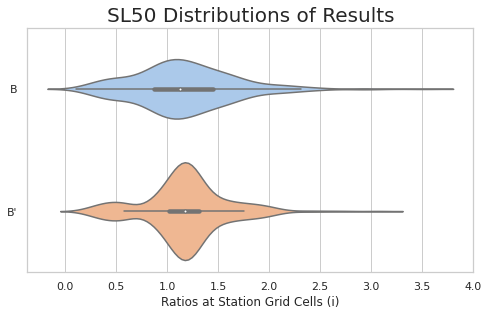

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 1.9417615457625375 
UAA_station_mean 1.5000000000000002 
Combined 1.720880772881269


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: kPa


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


f: 1.1231758574532946


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)